## PS 5
## Donghai YU
## Feb. 18

## Q1

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as lin

import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
from scipy.interpolate import LSQUnivariateSpline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
cmap1 = matplotlib.cm.get_cmap('summer')
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

/Users/donghaiy/Desktop/Macs_30100/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/donghaiy/Desktop/Macs_30100/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
data = pd.read_csv('strongdrink.txt')
data.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
data.cultivar.value_counts()


2    71
1    59
3    46
Name: cultivar, dtype: int64

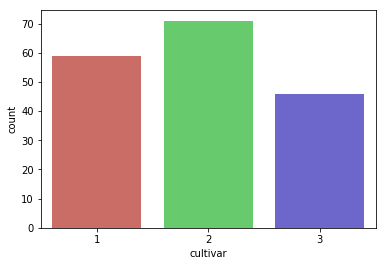

In [5]:
sns.countplot(x='cultivar', data=data, palette='hls')
